# Astronomical object classification

### Imports

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder,StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


### Reading the data

In [4]:
df = pd.read_csv('train.csv')
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232
9,1.237680e+18,328.092076,18.220310,25.77163,22.52042,20.63884,19.78071,19.05765,8102,301,3,27,5.652162e+18,GALAXY,0.459596,5020,55852,525


**Comment**: The training dataset has 80000 samples with 'class' as target variables and 17 other features.

### EDA

In [5]:
# Statiscal summary:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,8.000000e+04,80000.000000,80000.000000,79638.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.0,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000
mean,1.237665e+18,177.579220,24.132590,21.961115,20.507677,19.647426,19.085051,18.644640,4477.876713,301.0,3.511388,185.663050,5.783094e+18,0.577219,5136.309963,55587.191400,448.887437
std,8.424878e+12,96.409584,19.650113,35.581856,35.483302,1.855636,1.757630,35.462189,1961.579187,0.0,1.589033,148.433559,3.327780e+18,0.731597,2955.646539,1809.144282,272.328619
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995801e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.643892,5.170723,20.353990,18.963188,18.135523,17.732600,17.457503,3185.000000,301.0,2.000000,82.000000,2.841535e+18,0.055160,2523.750000,54233.000000,221.000000
50%,1.237663e+18,180.761747,23.603480,22.187965,21.101015,20.127550,19.405635,19.004420,4188.000000,301.0,4.000000,146.000000,5.606066e+18,0.425051,4979.000000,55868.000000,432.000000
75%,1.237668e+18,233.815698,39.904905,23.698457,22.125007,21.047242,20.401857,19.923013,5326.000000,301.0,5.000000,240.000000,8.331746e+18,0.704777,7400.000000,56777.000000,644.000000
max,1.237681e+18,359.999615,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [6]:
# Check samples where one of 'u', 'g', 'z' has value smaller than 0
df[(df['u'] < 0) | (df['g'] < 0) | (df['z'] < 0)]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
63607,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


**Comment**: It is noticable that 'u', 'g', and 'z' has minimum value at -9999, which so very far from the mean and maximum value. There is absolutely one 1 samples where these three features have -9999. This must be an outlier.

In [7]:
# Check missing values
df.isna().any()

obj_ID         False
alpha          False
delta          False
u               True
g              False
r              False
i              False
z              False
run_ID         False
rerun_ID       False
cam_col        False
field_ID       False
spec_obj_ID    False
class          False
redshift       False
plate          False
MJD            False
fiber_ID       False
dtype: bool

In [8]:
# Observe rows having missing values at feature 'u'
pd.DataFrame(df[df.isna().any(axis = 1)])

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
397,1.237668e+18,243.674064,9.251630,NaN,17.41451,17.47570,17.40724,17.54673,5322,301,3,228,2.847483e+18,QSO,0.628203,2529,54585,300
401,1.237679e+18,2.891353,1.480128,NaN,21.74609,21.85504,21.92592,20.92474,7712,301,1,349,4.839199e+18,QSO,2.227015,4298,55511,294
513,1.237651e+18,184.833910,-2.004270,NaN,21.64660,21.53089,21.46142,20.81839,1231,301,5,104,4.252749e+18,QSO,2.286136,3777,55210,818
603,1.237668e+18,220.769515,14.164362,NaN,21.59484,21.31533,21.57566,21.58218,5322,301,3,75,6.162211e+18,QSO,2.643308,5473,56033,584
642,1.237658e+18,179.468486,54.324141,NaN,20.20231,20.06267,19.97901,20.07419,2821,301,2,181,7.531384e+18,QSO,1.453503,6689,56396,870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79524,1.237668e+18,136.425633,17.655753,NaN,22.65696,21.96614,21.13199,20.85997,5137,301,5,158,1.075915e+19,QSO,0.648190,9556,57805,168
79540,1.237649e+18,150.229991,-0.929703,NaN,21.12765,20.96447,21.03944,20.43203,756,301,1,230,4.311197e+18,QSO,2.423274,3829,55300,460
79541,1.237658e+18,149.508362,50.758880,NaN,17.34075,17.36986,17.44620,17.40734,2831,301,1,68,6.460431e+18,QSO,0.745731,5738,56002,64
79748,1.237658e+18,141.716794,47.433948,NaN,18.61372,18.60112,18.60454,18.45812,2831,301,1,27,6.545122e+18,QSO,2.384383,5813,56363,968


**Comment**: Among 17 features, only 'u' has missing values and this feature contains 362 missing samples out of 80000 total. So this number is not too significant and they can be both removed or imputed. 

However, if just putting the mean/median values of the whole columns would bring wrong information to the learning. So based on which class the sample belongs to, the imputed values will be the mean of 'u' values to that particular class.

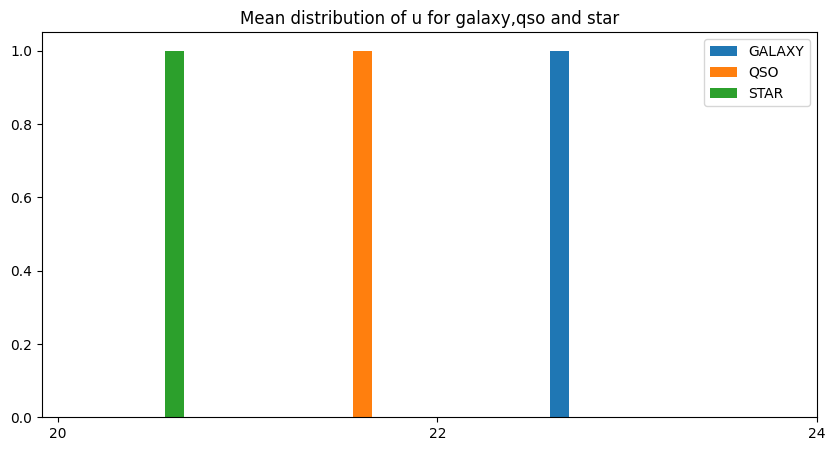

In [9]:
plt.figure(figsize = (10,5))
plt.hist(df[df['class']=='GALAXY']['u'].mean(),label = 'GALAXY');
plt.hist(df[df['class']=='QSO']['u'].mean(),label = 'QSO');
plt.hist(df[df['class']=='STAR']['u'].mean(),label = 'STAR');
plt.xticks(list(range(20,25,2)))
plt.title('Mean distribution of u for galaxy,qso and star');
plt.legend();

In [10]:
# Check for duplicated samples:
df.duplicated().any()

np.False_

**Comment**: There is no duplicated data.

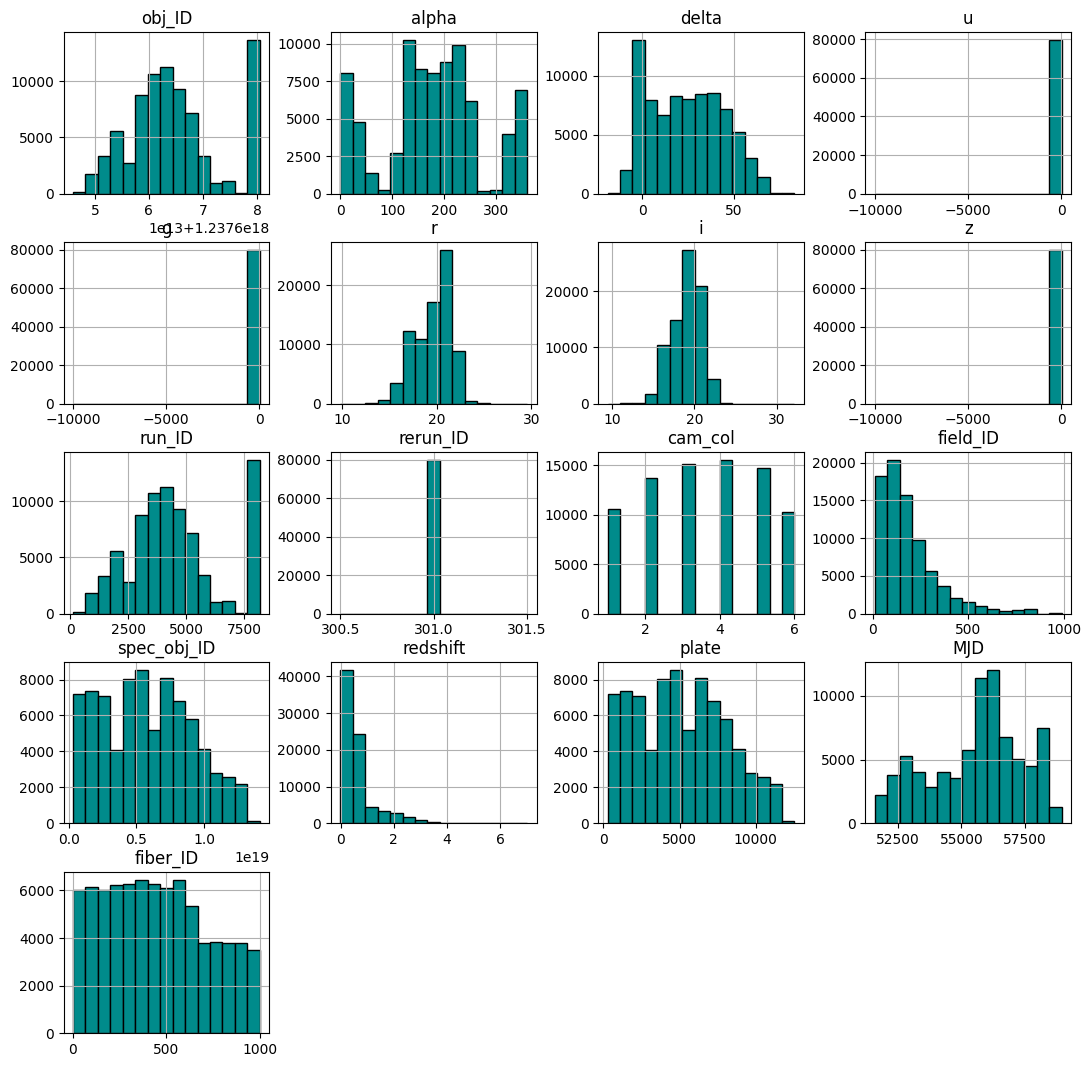

In [11]:
# Histograms for 17 features
df.drop(['class'],axis=1).hist(figsize=(13,13), 
                               bins = 15, color = 'darkcyan',
                               edgecolor='black')
plt.show()

**Comment**: Each feature has distinguish distribution. 
- Feature 'u', 'g', 'z' are very suspicious that as observed from dataset, their values lies between 17-25. But in the histogram none of the datapoints has value above 0. The plot could be distorted by the existence of the value -9999 in these features.

-> Very importance: Removing '-9999' sample

- Feature 'rerun_ID' seems to have only 1 value: 301. This need to be checked.

- Each feature has different range to the data need to be scaled for less computation.

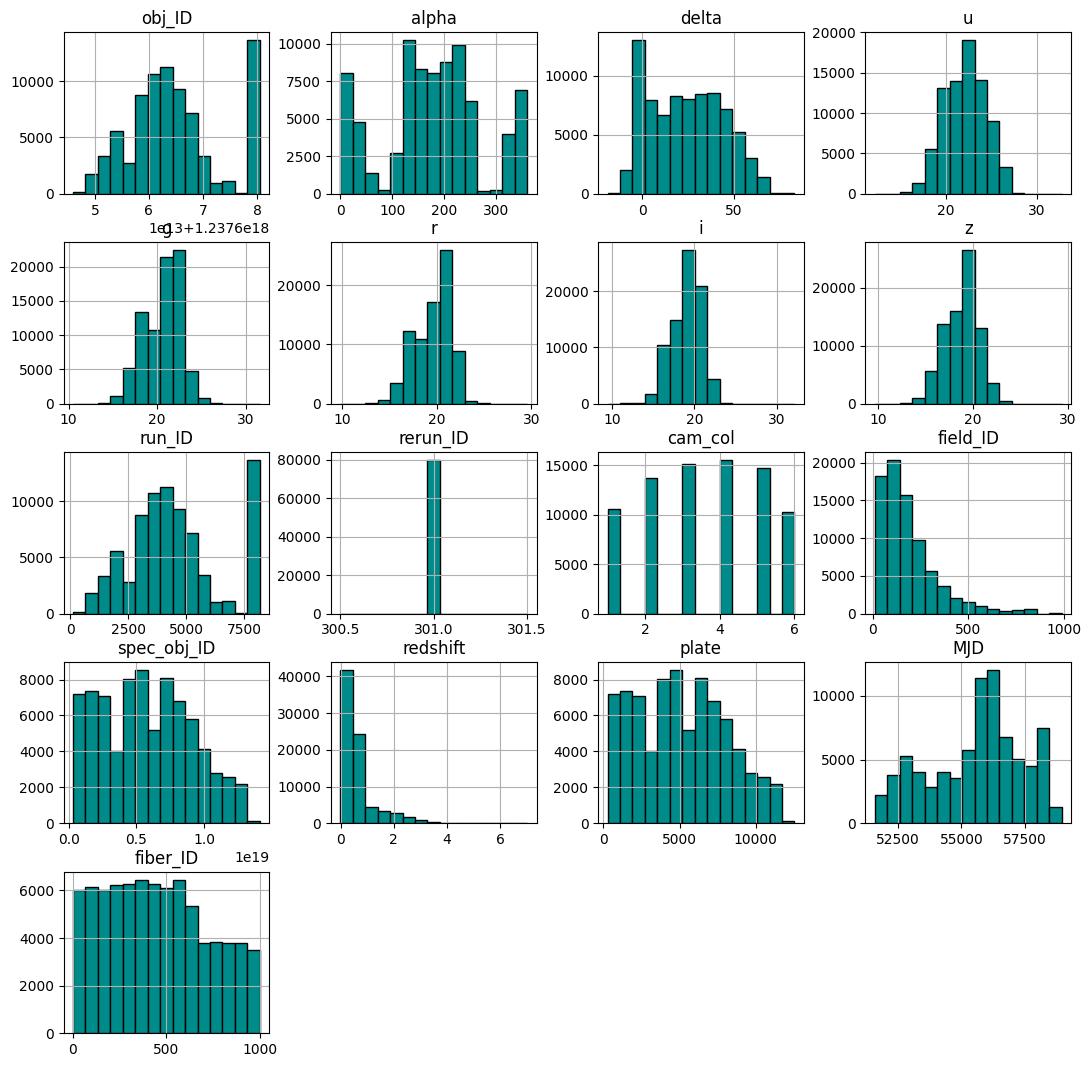

In [12]:
# Removing -9999 values
vars = ['u', 'g', 'z']
df = df[~df[vars].isin([-9999]).any(axis=1)]

df.drop(['class'],axis=1).hist(figsize=(13,13), 
                               bins = 15, color = 'darkcyan',
                               edgecolor='black')
plt.show()

**Comment**: Most of the features' distributions are skewed and unlikely to be Guassian.

In [13]:
# Check number of unique values in 'rerun_ID'
df['rerun_ID'].nunique()

1

**Comment**: This means all sample in training set has 301 as their 'rerun_ID' so this feature is not meaningful for the classification. The same happens in test set so 'rerun_ID' must be completely removed from train and test data.

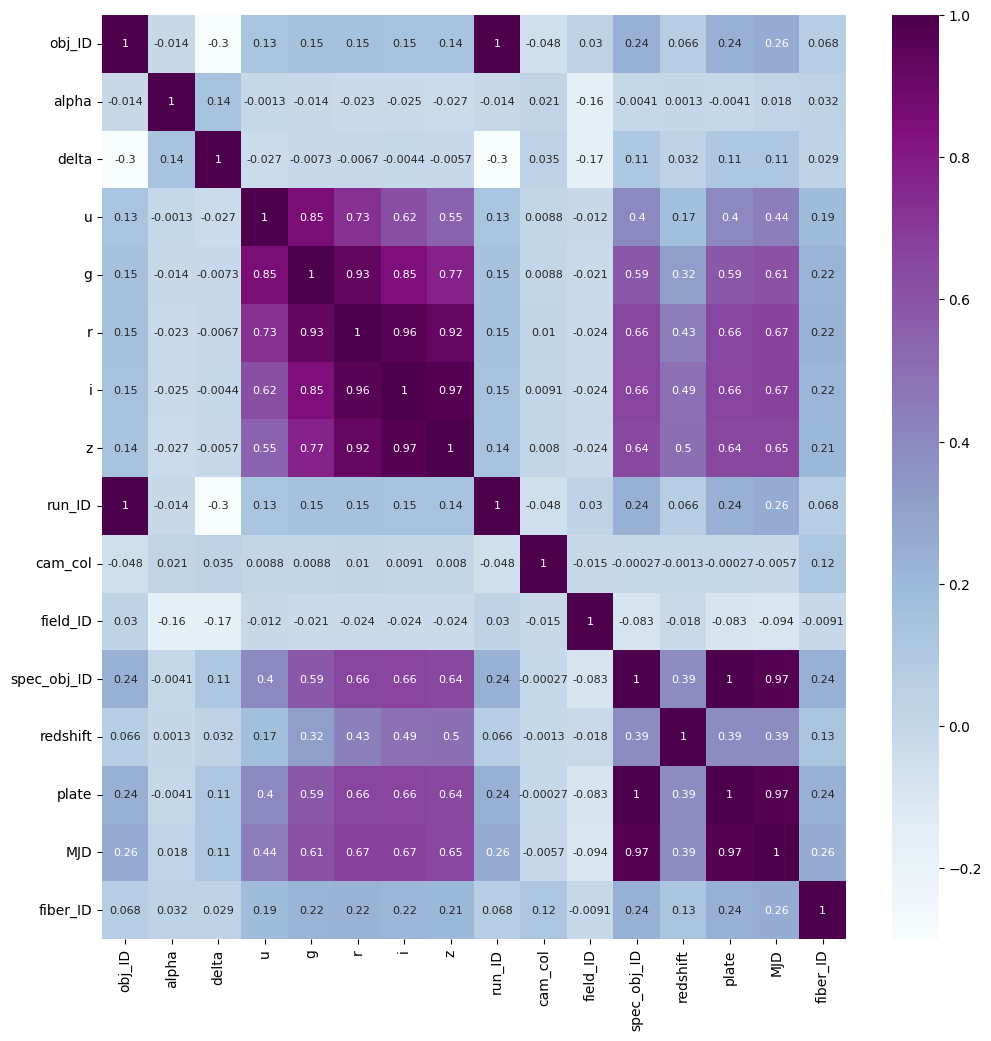

In [14]:
# Dataframe for current 16 features
features_df = df.drop(['class','rerun_ID'], axis =1)

# Correlation matrix:
plt.figure(figsize=(12, 12))
sns.heatmap(features_df.corr(), annot=True,
            annot_kws={'size': 8}, cmap="BuPu")
plt.show()

**Comment**: The heatmap shows some pairs of feature have very high correlation (somes at 1). 

- For those pairs have correlation of 1, the correlation of the features with the third features are exactly the same. Examples: ('obj_ID' vs 'run_ID') and ('spec_obj_ID' vs'plate').

!! This adds noise, increases training time so one of the features can be dropped. Because:

- 'obj_ID'= Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- 'run_ID' = Run Number used to identify the specific scan
- 'spec_obj_ID' = Unique ID used for optical spectroscopic objects 
- 'plate' = plate ID, identifies each plate in SDSS

They are not real features, just metadata so we can just keep one of each pair.


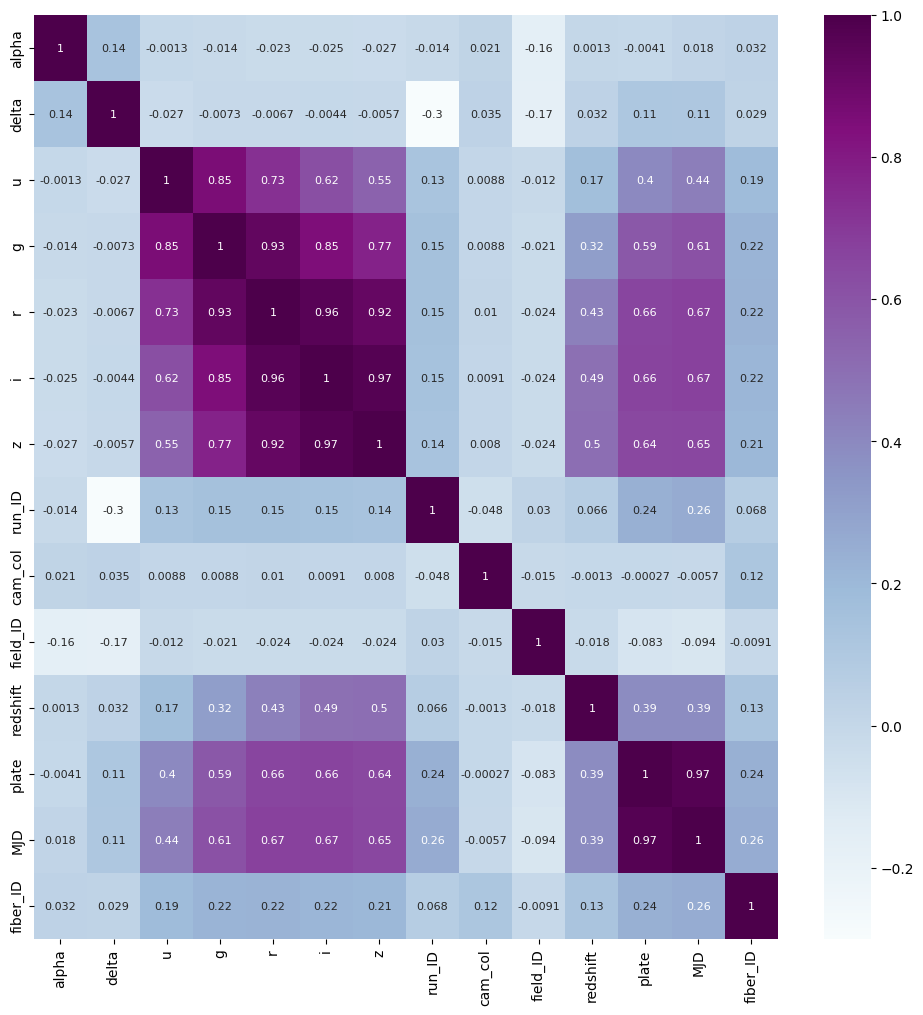

In [15]:
# Correlation matrix after removing 'obj_ID' and 'spec_obj_ID'
features_df = features_df.drop(['obj_ID','spec_obj_ID'], axis =1)

plt.figure(figsize=(12, 12))
sns.heatmap(features_df.corr(), annot=True,
            annot_kws={'size': 8}, cmap="BuPu")
plt.show()

**Comment**: Feature 'u', 'g', 'r', 'i', 'z' are highly correlated, why?

u = Ultraviolet filter in the photometric system

g = Green filter in the photometric system

r = Red filter in the photometric system

i = Near Infrared filter in the photometric system

z = Infrared filter in the photometric system

These filters are all measuring light intensity from the same object, just at different wavelengths.

In [16]:
combined_df = df[features_df.columns.tolist() + ['class']].copy()

sns.pairplot(combined_df, hue='class')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x283da3920> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

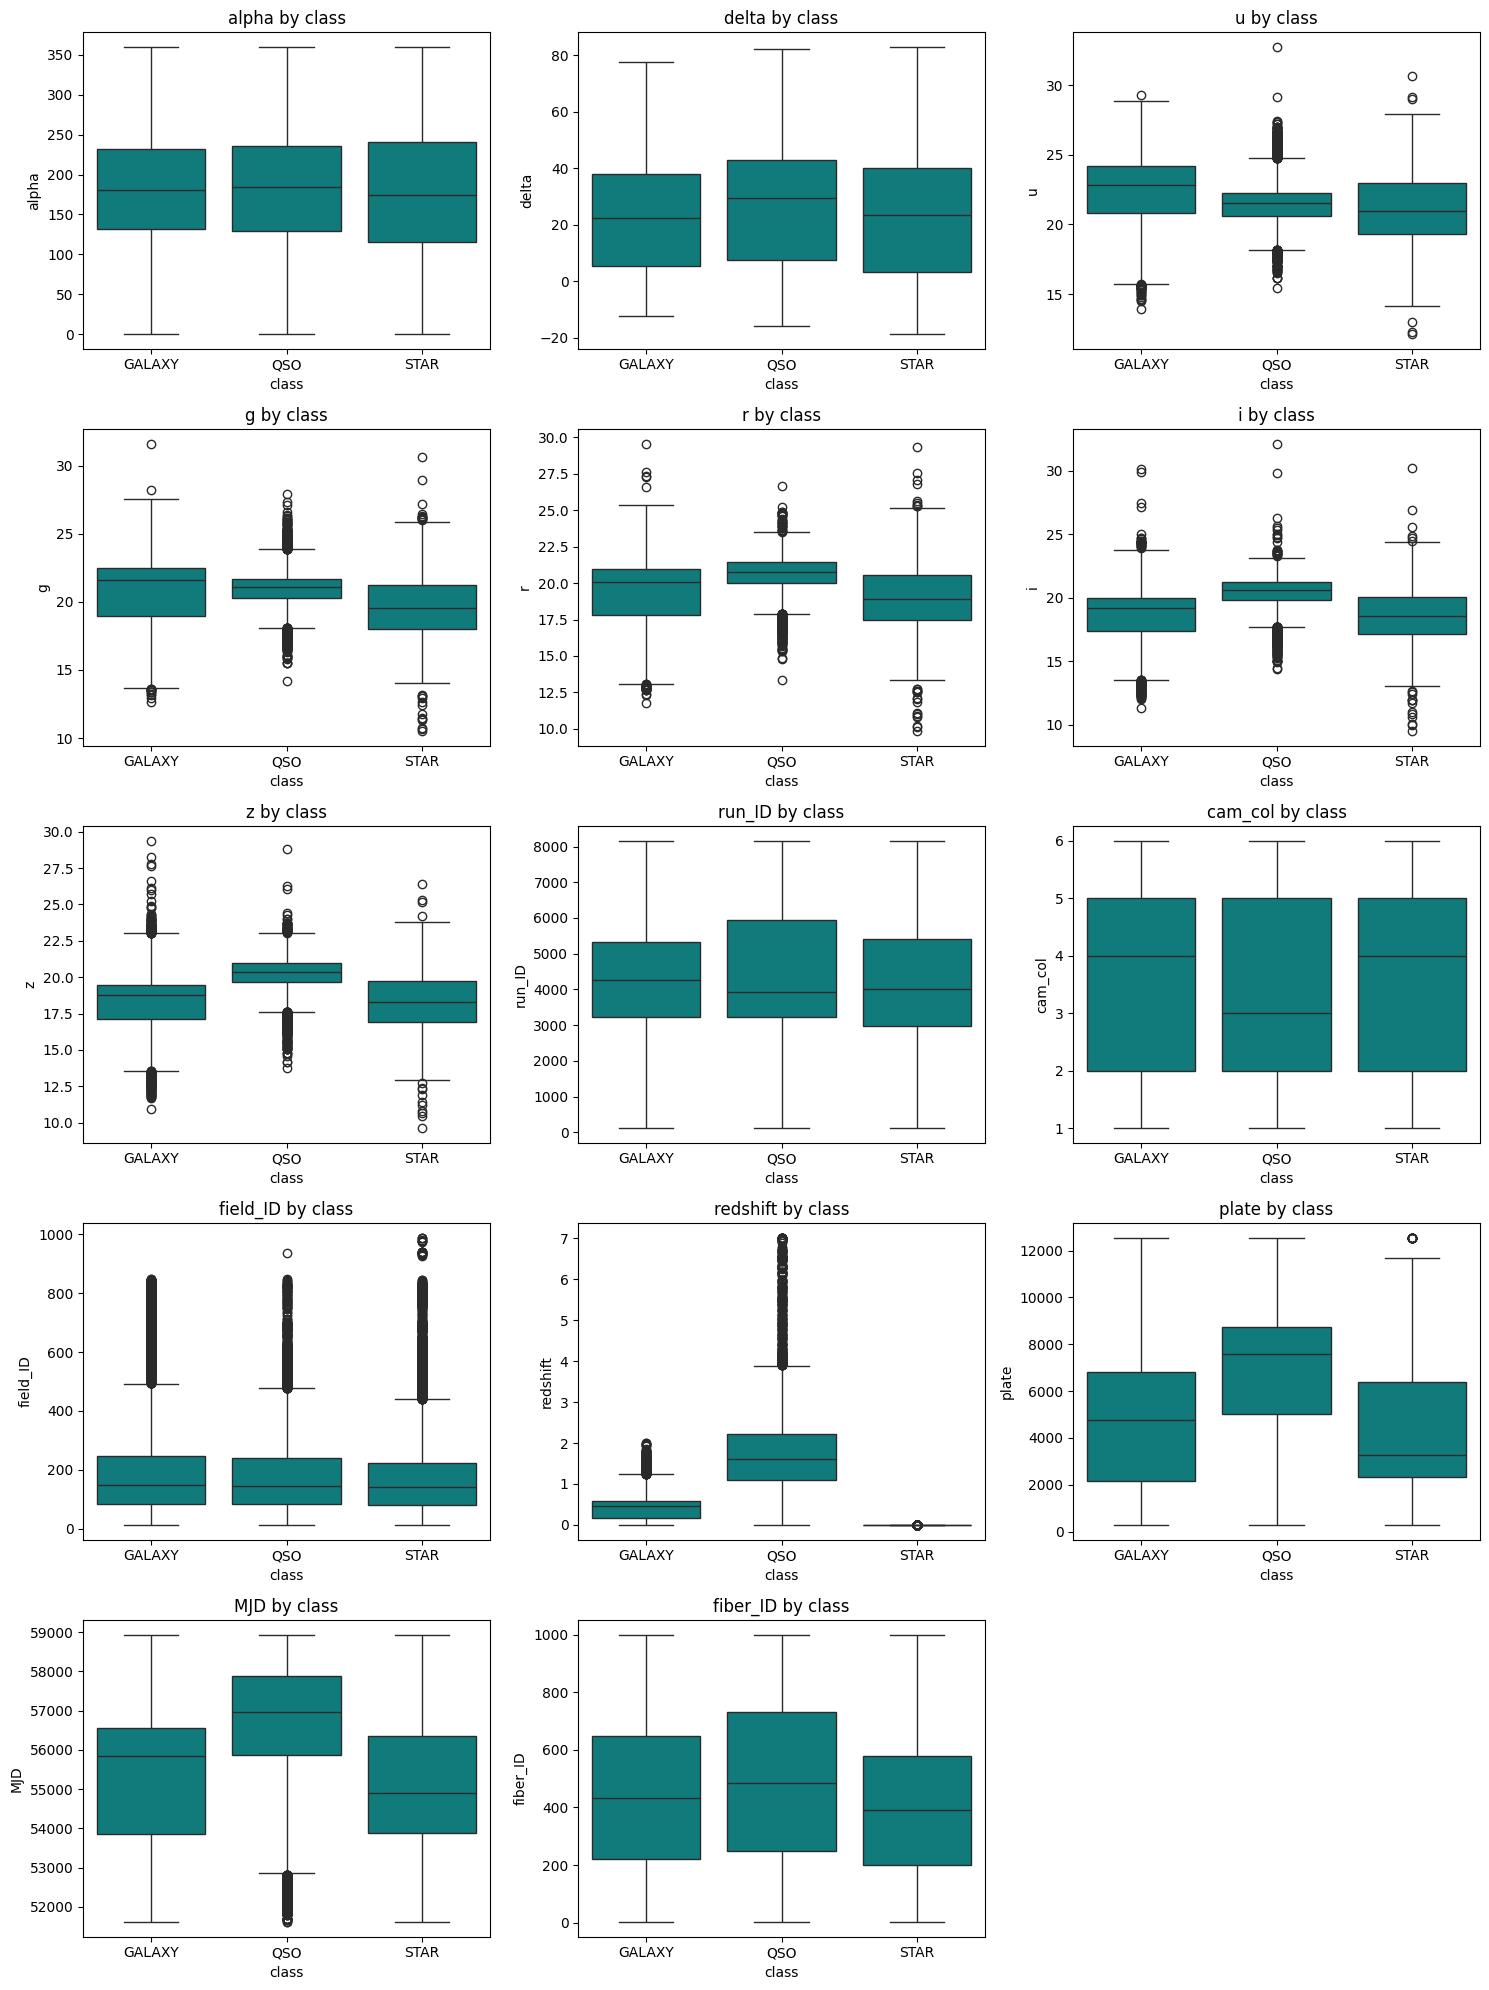

In [17]:
# Boxplots classified by 'class' and to see outliers:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()  # Make it 1D for easy indexing

# Loop through features
for i, col in enumerate(features_df.columns):
    sns.boxplot(data=df, x='class', y=col, ax=axes[i],
                color = 'darkcyan')
    axes[i].set_title(f'{col} by class')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Because we saw that most of features are skewed / not Guassian so it seems that z-score is not applicable to remove the outliers. Then we try the Interquartile Range (IQR) method, but only on some specific columns like 'u', 'z', 'i', 'z', 'MJD', 'redshift'.

In [18]:
# Removing outliers:
def remove_outliers_iqr(df, columns):
    filtered_df = df.copy()
    for column in columns:
        Q1 = filtered_df[column].quantile(0.25)
        Q3 = filtered_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2.5 * IQR
        upper_bound = Q3 + 2.5 * IQR
        filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]
    return filtered_df

cleaned_df = remove_outliers_iqr(df, ['u', 'z', 'i', 'z', 'MJD', 'redshift'])


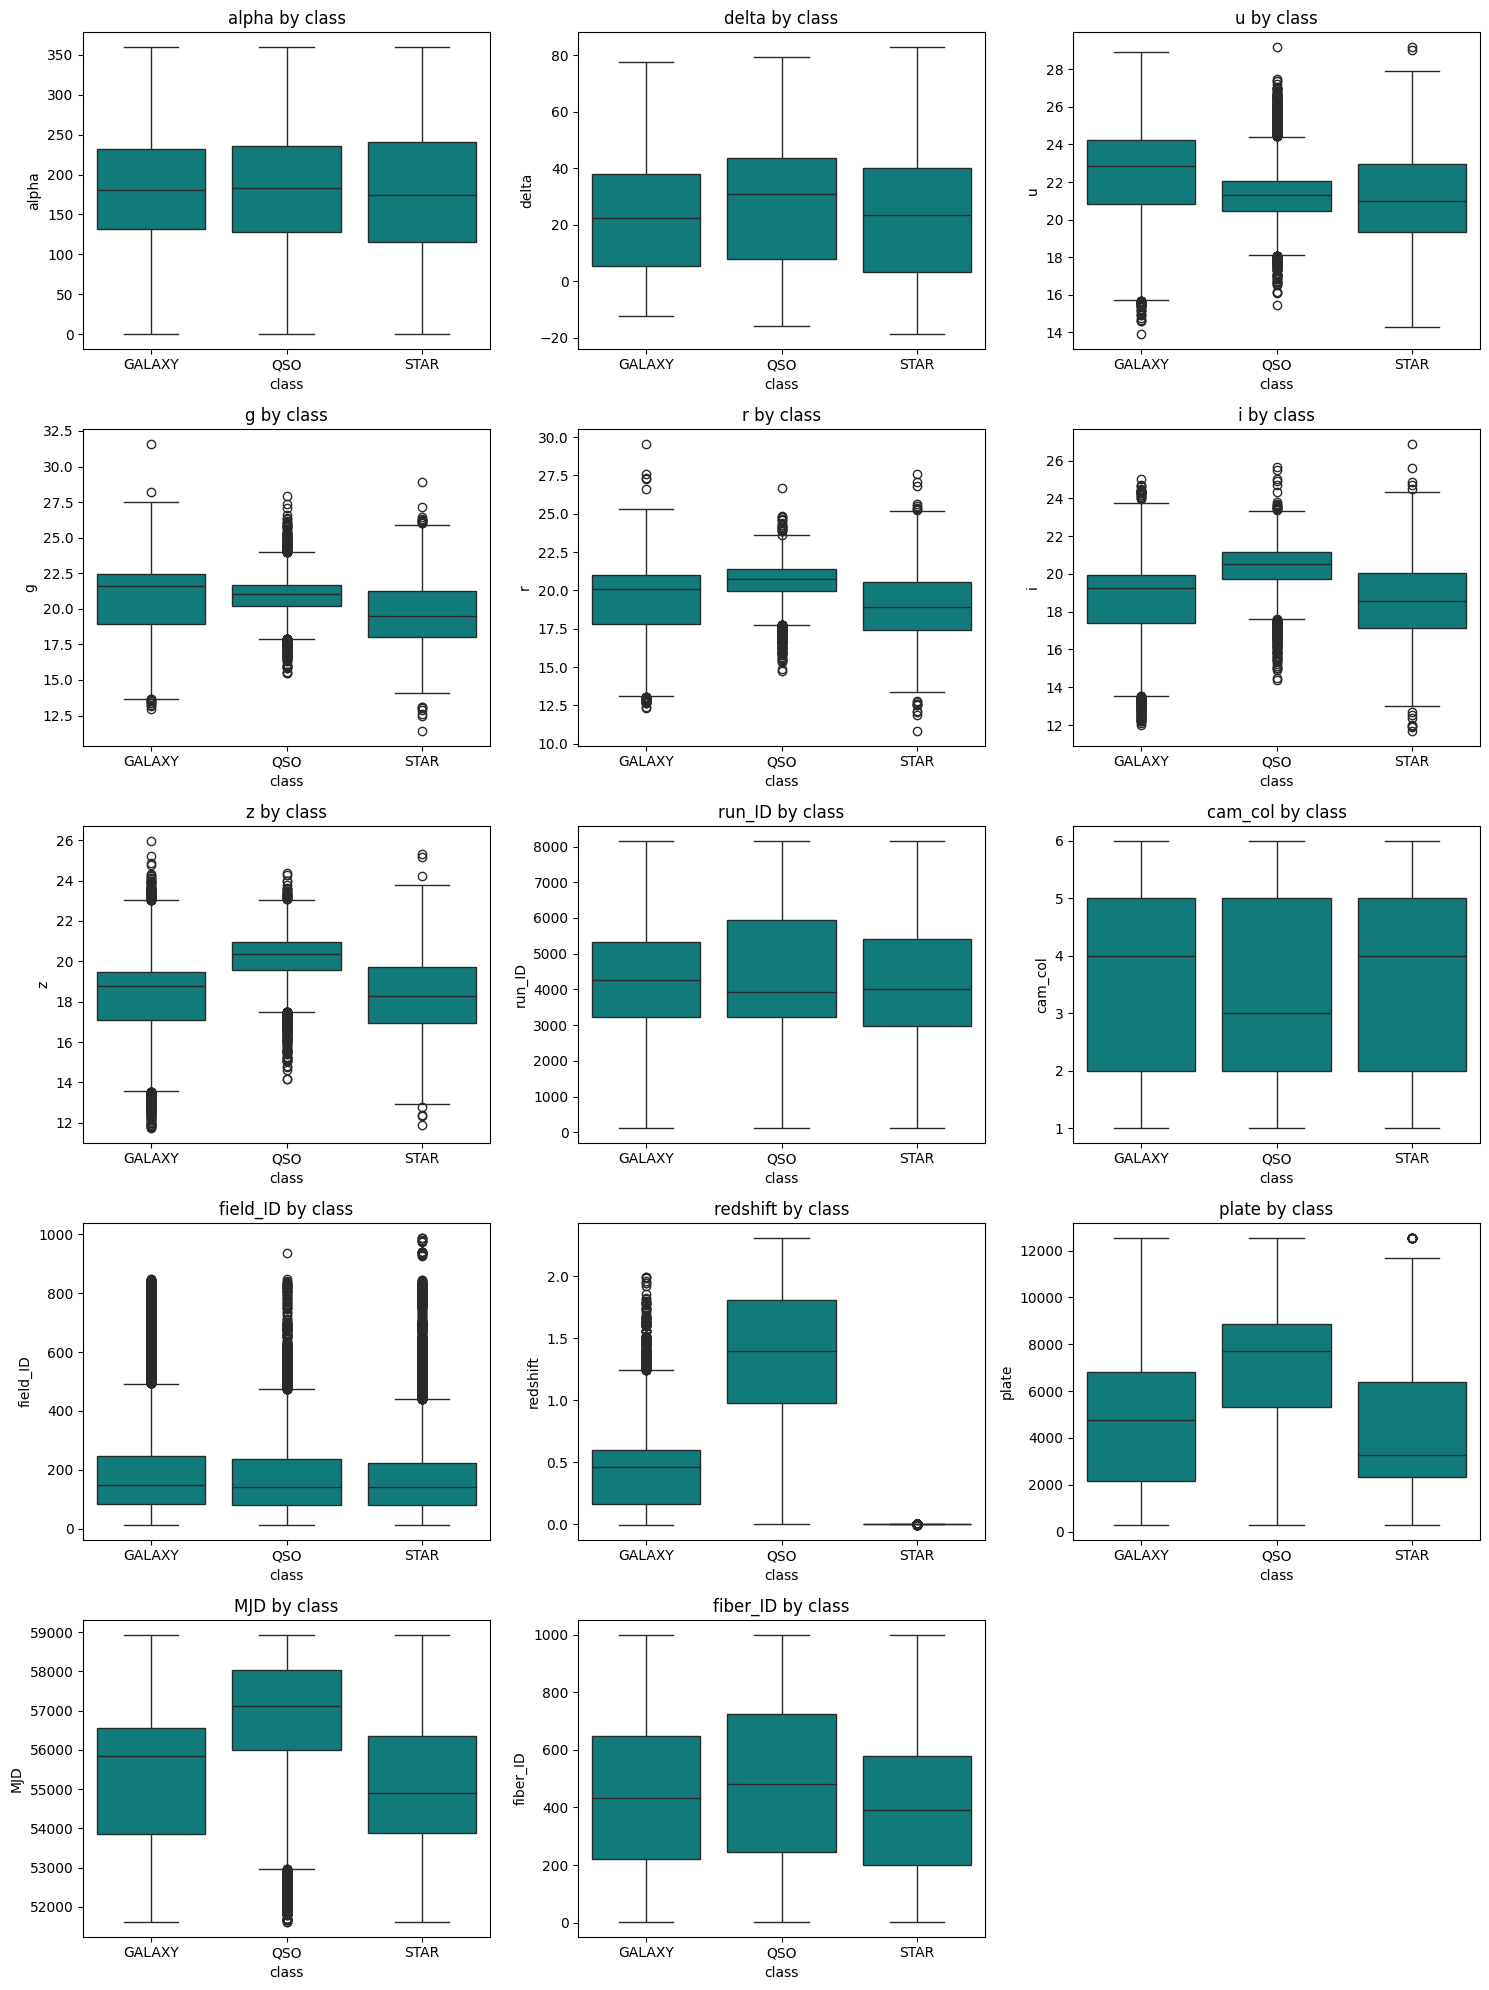

In [19]:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()  

# Loop through features
for i, col in enumerate(features_df.columns):
    sns.boxplot(data=cleaned_df, x='class', y=col, ax=axes[i],
                color = 'darkcyan')
    axes[i].set_title(f'{col} by class')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

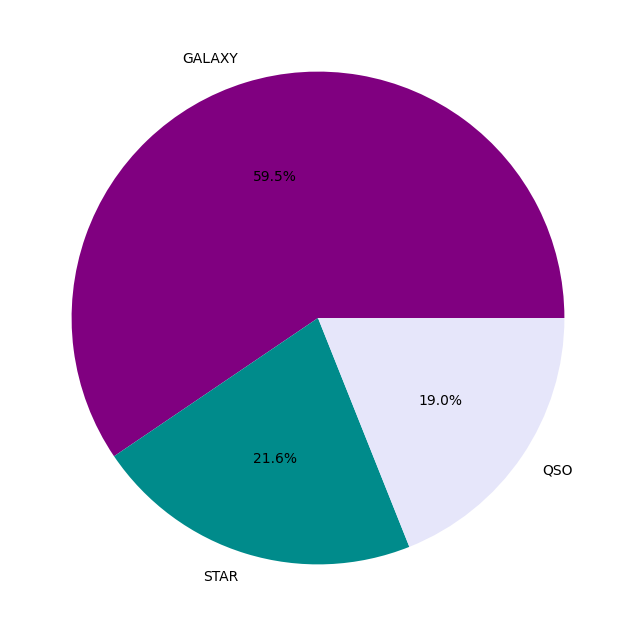

In [20]:
classes = df['class'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(classes, labels= classes.index, autopct= '%1.1f%%', 
        colors=['purple', 'darkcyan', 'lavender'])
plt.show()

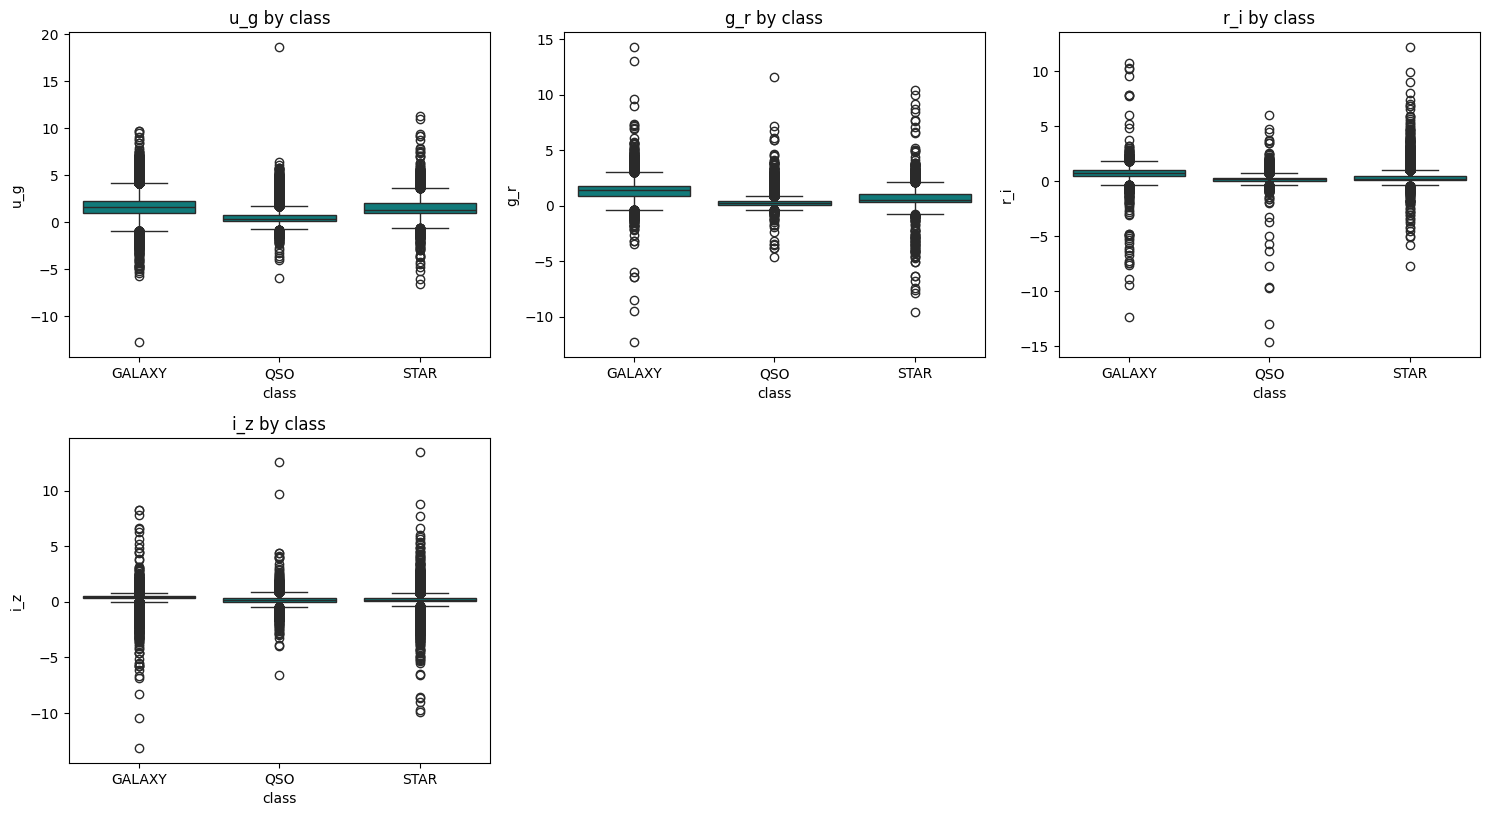

In [21]:
df['u_g'] = df['u'] - df['g']
df['g_r'] = df['g'] - df['r']
df['r_i'] = df['r'] - df['i']
df['i_z'] = df['i'] - df['z']

# Boxplots classified by 'class' and to see outliers:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()  # Make it 1D for easy indexing

# Loop through features
for i, col in enumerate(['u_g', 'g_r', 'r_i', 'i_z']):
    sns.boxplot(data=df, x='class', y=col, ax=axes[i],
                color = 'darkcyan')
    axes[i].set_title(f'{col} by class')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

**Summary**: To sum up what we are going to preprocess data

*For training only*:
- Remove samples with '-9999' values at features : only training
- Impute nan values in 'u' with the mean of each class.
- Remove outliers with 2.5*IQR

*Both training and test*:
- Scaling
- Encode the 'class'
- Remove 'rerun_ID', 'obj_ID', 'spec_obj_ID' columns.

In [5]:

def remove_minus_9999(df, features):
    return df[~(df[features] == -9999).any(axis=1)].copy()

def impute_u_by_class(df, target_col='class'):
    means = df.groupby(target_col)['u'].mean()
    for cls, mean_val in means.items():
        mask = (df[target_col] == cls) & (df['u'].isnull())
        df.loc[mask, 'u'] = mean_val
    return df

def remove_outliers_iqr(df, features, threshold=2.5):
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df.copy()

def feature_engineer(df):
    df = df.copy()
    df['u_g'] = df['u'] - df['g']
    df['g_r'] = df['g'] - df['r']
    df['r_i'] = df['r'] - df['i']
    df['i_z'] = df['i'] - df['z']
    return df

def drop_columns(df, cols):
    return df.drop(columns=cols, errors='ignore')

DROP_COLS = ['rerun_ID', 'obj_ID', 'spec_obj_ID']
FILTER_COLS = ['u', 'g', 'r', 'i', 'z']



In [7]:
final_df = pd.read_csv('train.csv')

le = LabelEncoder()
final_df['class'] = le.fit_transform(final_df['class'])

final_df = remove_minus_9999(final_df, FILTER_COLS)
final_df = impute_u_by_class(final_df, target_col='class')
final_df = remove_outliers_iqr(final_df, features=FILTER_COLS + ['MJD', 'redshift'])

In [8]:
# Split data
X = final_df.drop(columns='class')
y = final_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
scale_transform = ColumnTransformer([
    ('scale', StandardScaler(), make_column_selector(dtype_include='number'))
])

preprocess_pipe = Pipeline([
    ('feature_eng', FunctionTransformer(feature_engineer)),
    ('drop_cols', FunctionTransformer(lambda df: drop_columns(df, DROP_COLS))),
    ('scale', scale_transform)
])


In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create AdaBoost with base estimator
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier()
)

pip1 = Pipeline([
    ('preprocessing', preprocess_pipe),
    ('classifier', ada)
])


param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__estimator__max_depth': [3, 5, 7],
    'classifier__estimator__min_samples_leaf': [1, 5, 10]
}

grid = GridSearchCV(pip1, param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train, y_train)

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

Best score: 0.9783603403837124
Best params: {'classifier__estimator__max_depth': 7, 'classifier__estimator__min_samples_leaf': 1, 'classifier__n_estimators': 200}


In [11]:
df_test = pd.read_csv('test.csv')
test_prediction =pip1.predict(df_test)
y_test_kaggle = pd.DataFrame(test_prediction, columns=["class"])
y_test_kaggle.index.name = "ID"
y_test_kaggle[['class']].to_csv("kaggle1.csv")
